In [1]:
import os, sys, random, glob, re
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt

SEED = 42

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception:
        pass

set_seed(SEED)

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import importlib

def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    try:
        importlib.import_module(pkg)
        return True
    except Exception:
        if "google.colab" in sys.modules:
            import subprocess, sys as _sys
            subprocess.check_call([_sys.executable, "-m", "pip", "install", pip_name])
            return True
        else:
            raise

ensure("SimpleITK", "SimpleITK")
ensure("scipy")
ensure("nibabel")

True

In [3]:
from pathlib import Path
PROJECT_ROOT = Path("/content/drive/MyDrive/MS_DATA/DataMSLesion2008/")

DATA_DIR = PROJECT_ROOT / "data"

DICOM_ROOT = DATA_DIR / "raw"

PROC_DIR = DATA_DIR / "processed"

FCM_DIR = DATA_DIR / "fcm"

META_PATH = DATA_DIR / "metadata.json"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DICOM_ROOT :", DICOM_ROOT)
print("PROC_DIR   :", PROC_DIR)
print("FCM_DIR    :", FCM_DIR)
print("META_PATH  :", META_PATH)

PROJECT_ROOT: /content/drive/MyDrive/MS_DATA/DataMSLesion2008
DICOM_ROOT : /content/drive/MyDrive/MS_DATA/DataMSLesion2008/data/raw
PROC_DIR   : /content/drive/MyDrive/MS_DATA/DataMSLesion2008/data/processed
FCM_DIR    : /content/drive/MyDrive/MS_DATA/DataMSLesion2008/data/fcm
META_PATH  : /content/drive/MyDrive/MS_DATA/DataMSLesion2008/data/metadata.json


In [4]:
import SimpleITK as sitk

DICOM_ROOT = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1"
img_path = f"{DICOM_ROOT}/CHB_test1_Case01/CHB_test1_Case01_FLAIR.nhdr"

img = sitk.ReadImage(img_path)
arr = sitk.GetArrayFromImage(img)
print(arr.shape)

(512, 512, 512)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

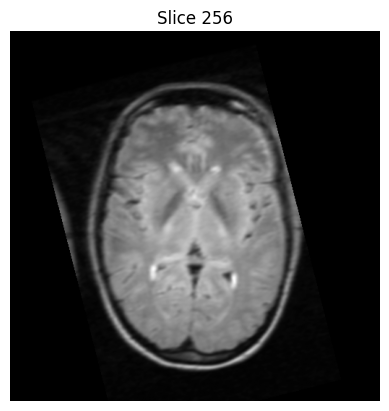

In [5]:
slice_idx = 256
plt.imshow(arr[slice_idx], cmap="gray")
plt.title(f"Slice {slice_idx}")
plt.axis("off")

In [6]:
img = sitk.ReadImage(img_path)

new_size = [128, 128, 128]
orig_size = np.array(list(img.GetSize()), dtype=np.int32)
orig_spacing = np.array(list(img.GetSpacing()), dtype=np.float32)

new_spacing = orig_spacing * (orig_size / np.array(new_size))
img_128 = sitk.Resample(
    img,
    new_size,
    sitk.Transform(),
    sitk.sitkLinear,
    img.GetOrigin(),
    list(new_spacing),
    img.GetDirection(),
    0.0,
    img.GetPixelID()
)

arr_128 = sitk.GetArrayFromImage(img_128).astype(np.float32)

mn, mx = float(arr_128.min()), float(arr_128.max())
arr_128 = (arr_128 - mn) / (mx - mn + 1e-8)
arr_128 = np.nan_to_num(arr_128, nan=0.0, posinf=1.0, neginf=0.0)

print("arr_128 shape:", arr_128.shape, "min/max:", arr_128.min(), arr_128.max())

arr_128 shape: (128, 128, 128) min/max: 0.0 1.0


##FCM (Fuzzy C-Means)

In [ ]:
def fcm_1d(data, c=3, m=2.0, max_iter=50, tol=1e-5, seed=42):
    """
    data: 1D array (N,)
    returns: centers (c,), membership (c, N)
    """
    rng = np.random.default_rng(seed)
    N = data.shape[0]

    U = rng.random((c, N)).astype(np.float32)
    U = U / (U.sum(axis=0, keepdims=True) + 1e-8)

    for _ in range(max_iter):
        U_m = U ** m
        centers = (U_m @ data) / (U_m.sum(axis=1) + 1e-8)

        dist = np.abs(data[None, :] - centers[:, None]) + 1e-8

        inv_dist = dist ** (-2.0 / (m - 1.0))
        U_new = inv_dist / (inv_dist.sum(axis=0, keepdims=True) + 1e-8)

        if np.max(np.abs(U_new - U)) < tol:
            U = U_new
            break
        U = U_new

    return centers.astype(np.float32), U.astype(np.float32)

vol = arr_128

brain_mask = vol > 0.05
vals = vol[brain_mask].reshape(-1).astype(np.float32)

centers, U = fcm_1d(vals, c=3, m=2.0, max_iter=60)

bright_cluster = int(np.argmax(centers))
membership_bright = U[bright_cluster]


fcm_prob = np.zeros_like(vol, dtype=np.float32)
fcm_prob[brain_mask] = membership_bright

fcm_mask = (fcm_prob > 0.6).astype(np.uint8)

print("FCM centers:", centers)
print("fcm_prob min/max:", fcm_prob.min(), fcm_prob.max(), "mask sum:", int(fcm_mask.sum()))


FCM centers: [0.12092394 0.33120123 0.5445432 ]
fcm_prob min/max: 0.0 0.9999773 mask sum: 157599


In [8]:
X = np.stack([arr_128, fcm_prob], axis=-1).astype(np.float32)
print("Model input shape:", X.shape)

Model input shape: (128, 128, 128, 2)


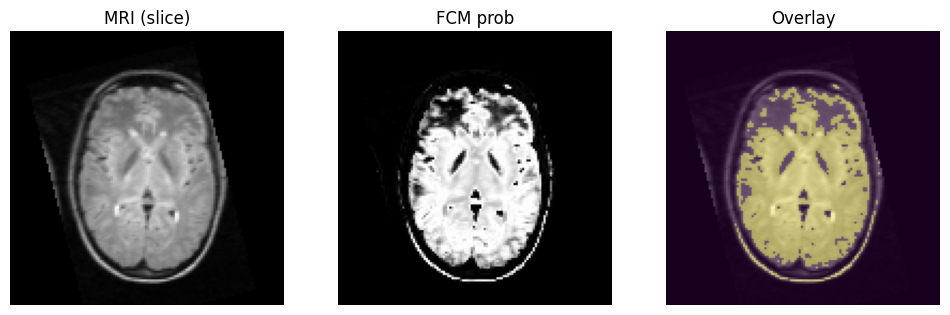

In [9]:
z = 64
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(arr_128[z], cmap="gray")
plt.title("MRI (slice)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(fcm_prob[z], cmap="gray")
plt.title("FCM prob")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(arr_128[z], cmap="gray")
plt.imshow(fcm_mask[z], alpha=0.35)
plt.title("Overlay")
plt.axis("off")

plt.show()

In [10]:
thr = 0.85
fcm_mask = (fcm_prob > thr).astype(np.uint8)
print("mask sum:", int(fcm_mask.sum()))

mask sum: 118320


In [ ]:
total = fcm_mask.size                 
brain = int((arr_128 > 0.12).sum())  
msk   = int(fcm_mask.sum())

print("Total vox:", total)
print("Brain vox:", brain)
print("Mask vox:", msk)
print("Mask/Total %:", 100*msk/total)
print("Mask/Brain %:", 100*msk/brain)

Total vox: 2097152
Brain vox: 357151
Mask vox: 118320
Mask/Total %: 5.641937255859375
Mask/Brain %: 33.1288446623417


In [12]:
brain_mask = arr_128 > 0.12
p = fcm_prob[brain_mask]

target = 0.03
thr = np.quantile(p, 1 - target)

fcm_mask_q = np.zeros_like(fcm_prob, dtype=np.uint8)
fcm_mask_q[brain_mask] = (p >= thr).astype(np.uint8)

print("quantile thr:", float(thr))
print("Mask/Brain %:", 100 * fcm_mask_q.sum() / brain_mask.sum())
print("Mask vox:", int(fcm_mask_q.sum()))

quantile thr: 0.9992168545722961
Mask/Brain %: 3.253525819611313
Mask vox: 11620


In [13]:
import scipy.ndimage as ndi
labeled, n = ndi.label(fcm_mask_q)
sizes = ndi.sum(fcm_mask_q, labeled, index=range(1, n+1))

min_size = 80
keep = np.zeros(n+1, dtype=bool)
keep[1:] = sizes >= min_size

fcm_mask_clean = keep[labeled].astype(np.uint8)

print("before:", int(fcm_mask_q.sum()), "after:", int(fcm_mask_clean.sum()))
print("Clean Mask/Brain %:", 100 * fcm_mask_clean.sum() / brain_mask.sum())

before: 11620 after: 511
Clean Mask/Brain %: 0.143076737850377


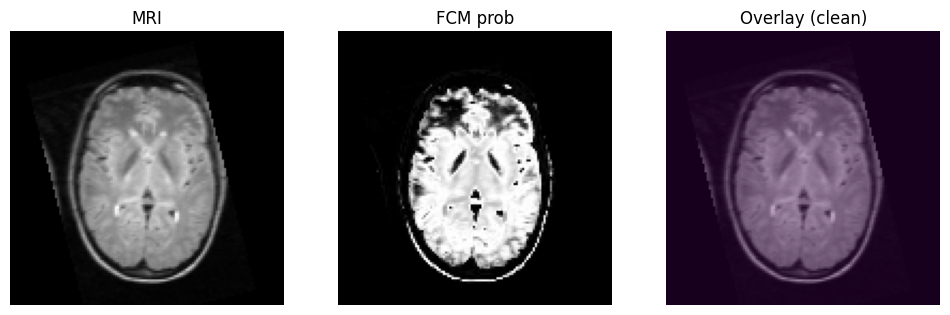

In [14]:
z = 64
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(arr_128[z], cmap="gray"); plt.title("MRI"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(fcm_prob[z], cmap="gray"); plt.title("FCM prob"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(arr_128[z], cmap="gray"); plt.imshow(fcm_mask_clean[z], alpha=0.35); plt.title("Overlay (clean)"); plt.axis("off")
plt.show()

In [15]:
print("mask vox:", int(fcm_mask_clean.sum()))
z_best = int(np.argmax(fcm_mask_clean.sum(axis=(1,2))))
print("en çok maske olan slice:", z_best, "vox:", int(fcm_mask_clean[z_best].sum()))

mask vox: 511
en çok maske olan slice: 75 vox: 46


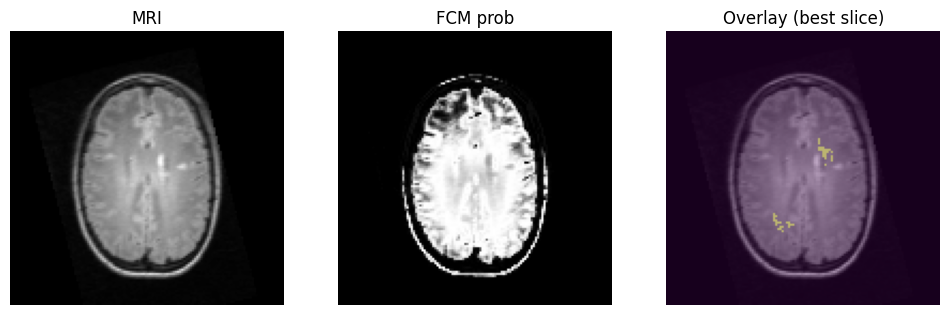

In [16]:
z = z_best
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(arr_128[z], cmap="gray"); plt.title("MRI"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(fcm_prob[z], cmap="gray"); plt.title("FCM prob"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(arr_128[z], cmap="gray"); plt.imshow(fcm_mask_clean[z], alpha=0.35); plt.title("Overlay (best slice)"); plt.axis("off")
plt.show()

In [17]:
# 2.Kanalı oluşturuz
X = np.stack([arr_128, fcm_prob], axis=-1).astype(np.float32)
print("X shape:", X.shape)

X shape: (128, 128, 128, 2)


In [18]:
#Ground Truth (etiket) var mı?

case_dir = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case01"
files = sorted(glob.glob(case_dir + "/*"))
for f in files:
    print(os.path.basename(f))

CHB_test1_Case01_FLAIR.nhdr
CHB_test1_Case01_FLAIR.raw
CHB_test1_Case01_T1.nhdr
CHB_test1_Case01_T1.raw
CHB_test1_Case01_T2.nhdr
CHB_test1_Case01_T2.raw


## Veri seti hazırlığı (zip açma, klasör kontrol)

In [19]:
ROOT = "/content/drive/MyDrive/MS_DATA"

keywords = ["mask", "lesion", "seg", "truth", "label", "gt", "gold"]
hits = []

for dirpath, dirnames, filenames in os.walk(ROOT):
    for fn in filenames:
        low = fn.lower()
        if any(k in low for k in keywords):
            hits.append(os.path.join(dirpath, fn))

print("Bulunan label adayları:", len(hits))
for h in hits[:50]:
    print(h)

Bulunan label adayları: 104
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesionSegmentation_linux32.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesionSegmentation_MacOSX_Intel.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesion.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesionSrc.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesionSegmentation_linux64.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case01/UNC_train_Case01_lesion_byCHB.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case01/UNC_train_Case01_lesion_byCHB.raw
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case02/UNC_train_Case02_lesion_byCHB.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case02/UNC_train_Case02_lesion_byCHB.raw
/content/drive/MyDrive/M

In [20]:
zip_path = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB.zip"
out_dir  = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB"

os.makedirs(out_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(out_dir)

print("Extracted to:", out_dir)
print("Top-level:", os.listdir(out_dir)[:30])

Extracted to: /content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB
Top-level: ['UNC_train_Case01', 'UNC_train_Case02', 'UNC_train_Case03', 'UNC_train_Case04', 'UNC_train_Case05', 'UNC_train_Case07', 'UNC_train_Case08', 'UNC_train_Case09', 'UNC_train_Case10']


In [21]:
for name in sorted(os.listdir(out_dir))[:30]:
    p = os.path.join(out_dir, name)
    print(("DIR " if os.path.isdir(p) else "FILE"), name)

DIR  UNC_train_Case01
DIR  UNC_train_Case02
DIR  UNC_train_Case03
DIR  UNC_train_Case04
DIR  UNC_train_Case05
DIR  UNC_train_Case07
DIR  UNC_train_Case08
DIR  UNC_train_Case09
DIR  UNC_train_Case10


In [22]:
train_root = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB"
keywords = ["mask", "lesion", "seg", "truth", "label", "gt", "gold"]

hits = []
for dirpath, _, filenames in os.walk(train_root):
    for fn in filenames:
        low = fn.lower()
        if any(k in low for k in keywords):
            hits.append(os.path.join(dirpath, fn))

print("Bulunan label dosyası:", len(hits))
for h in hits[:40]:
    print(h)

Bulunan label dosyası: 18
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case01/UNC_train_Case01_lesion_byCHB.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case01/UNC_train_Case01_lesion_byCHB.raw
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case02/UNC_train_Case02_lesion_byCHB.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case02/UNC_train_Case02_lesion_byCHB.raw
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case03/UNC_train_Case03_lesion_byCHB.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case03/UNC_train_Case03_lesion_byCHB.raw
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case04/UNC_train_Case04_lesion_byCHB.raw
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case04/UNC_train_Case04_lesion_byCHB

In [23]:
case01 = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB/UNC_train_Case01"
print("Case01 files:")
for f in sorted(glob.glob(case01 + "/*")):
    print(os.path.basename(f))

Case01 files:
UNC_train_Case01_lesion_byCHB.nhdr
UNC_train_Case01_lesion_byCHB.raw


In [24]:
cases = sorted([d for d in os.listdir(train_root) if d.startswith("UNC_train_Case")])

pairs = []
for c in cases:
    cdir = os.path.join(train_root, c)
    flair = glob.glob(os.path.join(cdir, "*FLAIR*.nhdr"))
    t1    = glob.glob(os.path.join(cdir, "*T1*.nhdr"))
    t2    = glob.glob(os.path.join(cdir, "*T2*.nhdr"))
    mask  = glob.glob(os.path.join(cdir, "*lesion_byCHB*.nhdr"))

    img = flair[0] if flair else (t1[0] if t1 else (t2[0] if t2 else None))
    msk = mask[0] if mask else None

    pairs.append((c, img, msk))

for c, img, msk in pairs:
    print(c, "IMG:", bool(img), "MASK:", bool(msk))

UNC_train_Case01 IMG: False MASK: True
UNC_train_Case02 IMG: False MASK: True
UNC_train_Case03 IMG: False MASK: True
UNC_train_Case04 IMG: False MASK: True
UNC_train_Case05 IMG: False MASK: True
UNC_train_Case07 IMG: False MASK: True
UNC_train_Case08 IMG: False MASK: True
UNC_train_Case09 IMG: False MASK: True
UNC_train_Case10 IMG: False MASK: True


In [25]:
keywords = ["flair", "t1", "t2", ".nhdr"]
hits = []

for dirpath, dirnames, filenames in os.walk(ROOT):
    for fn in filenames:
        low = fn.lower()
        if low.endswith(".nhdr") and any(k in low for k in ["flair", "t1", "t2"]):
            hits.append(os.path.join(dirpath, fn))

print("Bulunan görüntü nhdr sayısı:", len(hits))
for p in hits[:30]:
    print(p)

Bulunan görüntü nhdr sayısı: 48
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case05/CHB_test1_Case05_T1.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case05/CHB_test1_Case05_T2.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case05/CHB_test1_Case05_FLAIR.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case06/CHB_test1_Case06_FLAIR.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case06/CHB_test1_Case06_T1.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case06/CHB_test1_Case06_T2.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case01/CHB_test1_Case01_T1.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case01/CHB_test1_Case01_T2.nhdr
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1/CHB_test1_Case01/CHB_test1_Case01_FLAIR.nhdr
/cont

In [26]:
zips = glob.glob("/content/drive/MyDrive/MS_DATA/DataMSLesion2008/*.zip")
print("Zip sayısı:", len(zips))
for z in zips:
    print(z)

Zip sayısı: 15
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part1.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part2.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_test1_Part3.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_train_Part1.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesionSegmentation_linux32.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/CHB_train_Part2.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesionSegmentation_MacOSX_Intel.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesion.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesionSrc.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/EvalLesionSegmentation_linux64.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_test1_Part1.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_test1_Part2.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_Part1.zip
/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_

In [27]:
base = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008"
out_dir = f"{base}/UNC_train_images"
os.makedirs(out_dir, exist_ok=True)

for zname in ["UNC_train_Part1.zip", "UNC_train_Part2.zip"]:
    zip_path = f"{base}/{zname}"
    print("Extracting:", zip_path)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(out_dir)

print("Done ->", out_dir)
print("Top-level:", sorted(os.listdir(out_dir))[:30])


Extracting: /content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_Part1.zip
Extracting: /content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_Part2.zip
Done -> /content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_images
Top-level: ['UNC_train_Case01', 'UNC_train_Case02', 'UNC_train_Case03', 'UNC_train_Case04', 'UNC_train_Case05', 'UNC_train_Case06', 'UNC_train_Case07', 'UNC_train_Case08', 'UNC_train_Case09', 'UNC_train_Case10']


In [28]:
img_root = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_images"
print("FLAIR nhdr:", len(glob.glob(img_root + "/**/*FLAIR*.nhdr", recursive=True)))
print("T1 nhdr:",    len(glob.glob(img_root + "/**/*T1*.nhdr", recursive=True)))
print("T2 nhdr:",    len(glob.glob(img_root + "/**/*T2*.nhdr", recursive=True)))

FLAIR nhdr: 10
T1 nhdr: 10
T2 nhdr: 10


In [29]:
msk_root = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB"

def case_id(p):
    m = re.search(r"Case(\d+)", os.path.basename(p))
    return m.group(1) if m else None

img_files = glob.glob(os.path.join(img_root, "**", "*FLAIR*.nhdr"), recursive=True)
msk_files = glob.glob(os.path.join(msk_root, "**", "*lesion_byCHB*.nhdr"), recursive=True)

img_map = {case_id(p): p for p in img_files if case_id(p)}
msk_map = {case_id(p): p for p in msk_files if case_id(p)}

common = sorted(set(img_map) & set(msk_map))
print("Ortak case sayısı:", len(common))
print("Örnek:", common[:10])

pairs = [{"image": img_map[c], "label": msk_map[c]} for c in common]
print("pairs:", len(pairs))

Ortak case sayısı: 9
Örnek: ['01', '02', '03', '04', '05', '07', '08', '09', '10']
pairs: 9


In [30]:
src = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_images"
dst = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_images_nii"
os.makedirs(dst, exist_ok=True)

files = glob.glob(src + "/**/*.nhdr", recursive=True)
print("nhdr:", len(files))

for p in files:
    img = sitk.ReadImage(p)
    out = os.path.join(dst, os.path.basename(p).replace(".nhdr", ".nii.gz"))
    sitk.WriteImage(img, out)

print("done ->", dst)

nhdr: 50
done -> /content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_images_nii


In [31]:
import nibabel as nib

test_lbl = glob.glob(dst + "/*.nii.gz")[0]
lbl = nib.load(test_lbl).get_fdata()
print("Label unique:", set(lbl.flatten()))

Label unique: {np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0), np.float64(30.0), np.float64(31.0), np.float64(32.0), np.float64(33.0), np.float64(34.0), np.float64(35.0), np.float64(36.0), np.float64(37.0), np.float64(38.0), np.float64(39.0), np.float64(40.0), np.float64(41.0), np.float64(42.0), np.float64(43.0), np.float64(44.0), np.float64(45.0), np.float64(46.0), np.float64(47.0), np.float64(48.0), np.float64(49.0), np.float64(50.0), np.float64(51.0), np.float64(52.0), np.float64(53.0), np.float64(54.0), np.fl

##FCM probability map üretimi (volume üzerinden)

In [32]:
def fcm_prob_from_volume(vol, brain_thr=0.12, c=3, m=2.0, max_iter=50, tol=1e-5, seed=42):
    vol = vol.astype(np.float32)
    brain = vol > brain_thr
    x = vol[brain].reshape(-1)

    if x.size < 1000:
        return np.zeros_like(vol, dtype=np.float32)

    U, centers = fcm_1d(x, c=c, m=m, max_iter=max_iter, tol=tol, seed=seed)
    lesion_k = int(np.argmax(centers))
    p = U[lesion_k].astype(np.float32)

    prob = np.zeros_like(vol, dtype=np.float32)
    prob[brain] = p
    return prob

print("FCM helper hazır ✅")

FCM helper hazır ✅


In [33]:
import sys
import subprocess

def install_if_missing(pkg):
    try:
        __import__(pkg)
        print(f"✔ {pkg} already installed")
    except ImportError:
        print(f"⏳ Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_if_missing("monai")
install_if_missing("SimpleITK")
install_if_missing("nibabel")


⏳ Installing monai...
✔ SimpleITK already installed
✔ nibabel already installed


In [ ]:
from monai.transforms import MapTransform
class FCMProbMapd(MapTransform):
    '''
    MONAI map-transform:
    dict içindeki 'image' anahtarından FCM olasılık haritası üretir ve 'fcm' anahtarına yazar.
    '''
    def __init__(self, keys=("image",), fcm_key="fcm", **fcm_kwargs):
        super().__init__(keys)
        self.fcm_key = fcm_key
        self.fcm_kwargs = fcm_kwargs

    def __call__(self, data):
        d = dict(data)
        img = d[self.keys[0]]

        if img.ndim == 4:
            vol = img[0]
        else:
            vol = img

        fcm = fcm_prob_from_volume(vol, **self.fcm_kwargs)
        d[self.fcm_key] = fcm[None, ...].astype(np.float32)
        return d

print("FCMProbMapd hazır ✅")

FCMProbMapd hazır ✅


## 3D U-Net Modeli ile MS Lezyon Segmentasyonu

Bu bölümde, MRI görüntüsü ve FCM olasılık haritasını birlikte kullanan
iki kanallı (2-channel) 3D U-Net modeli tanımlanmış ve eğitilmiştir.

In [35]:
BASE = "/content/drive/MyDrive/MS_DATA/DataMSLesion2008"

MRI_DIR = os.path.join(BASE, "UNC_train_images_nii")
FCM_DIR = os.path.join(BASE, "UNC_train_fcmprob_nii")
LBL_DIR = os.path.join(BASE, "UNC_train_lesion_byCHB_nii")

print("MRI_DIR:", MRI_DIR)
print("FCM_DIR:", FCM_DIR)
print("LBL_DIR:", LBL_DIR)

mri_paths = sorted(glob.glob(os.path.join(MRI_DIR, "*.nii*")))
fcm_paths = sorted(glob.glob(os.path.join(FCM_DIR, "*.nii*")))
lbl_paths = sorted(glob.glob(os.path.join(LBL_DIR, "*.nii*")))

print("MRI:", len(mri_paths))
print("FCM:", len(fcm_paths))
print("LBL:", len(lbl_paths))

print("MRI sample:", os.path.basename(mri_paths[0]) if mri_paths else "EMPTY")
print("FCM sample:", os.path.basename(fcm_paths[0]) if fcm_paths else "EMPTY")
print("LBL sample:", os.path.basename(lbl_paths[0]) if lbl_paths else "EMPTY")


MRI_DIR: /content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_images_nii
FCM_DIR: /content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_fcmprob_nii
LBL_DIR: /content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB_nii
MRI: 50
FCM: 10
LBL: 20
MRI sample: UNC_train_Case01_FLAIR.nii.gz
FCM sample: Case01_FCMprob.nii.gz
LBL sample: UNC_train_Case01__UNC_train_Case01_lesion_byCHB.nii.gz


In [36]:
flair_paths = sorted(glob.glob(os.path.join(MRI_DIR, "*_FLAIR.nii*")))
fcm_paths_all = sorted(glob.glob(os.path.join(FCM_DIR, "*_FCMprob.nii*")))
lbl_paths_all = sorted(glob.glob(os.path.join(LBL_DIR, "*_lesion_byCHB.nii*")))

print("FLAIR:", len(flair_paths))
print("FCM:", len(fcm_paths_all))
print("LBL:", len(lbl_paths_all))

def cid_flair(p):
    m = re.search(r"(Case\d+)_FLAIR", os.path.basename(p))
    return m.group(1) if m else None

def cid_fcm(p):
    m = re.search(r"(Case\d+)_FCMprob", os.path.basename(p))
    return m.group(1) if m else None

def cid_lbl(p):
    m = re.search(r"(Case\d+)_lesion_byCHB", os.path.basename(p))
    return m.group(1) if m else None

flair_map = {cid_flair(p): p for p in flair_paths if cid_flair(p)}
fcm_map   = {cid_fcm(p): p for p in fcm_paths_all if cid_fcm(p)}
lbl_map   = {cid_lbl(p): p for p in lbl_paths_all if cid_lbl(p)}

common_ids = sorted(set(flair_map) & set(fcm_map) & set(lbl_map))
print("✅ Common cases:", len(common_ids))
print("IDs:", common_ids)

data = [{"mri": flair_map[c], "fcm": fcm_map[c], "label": lbl_map[c]} for c in common_ids]
print("✅ sample:", data[0] if data else "EMPTY")

FLAIR: 10
FCM: 10
LBL: 20
✅ Common cases: 10
IDs: ['Case01', 'Case02', 'Case03', 'Case04', 'Case05', 'Case06', 'Case07', 'Case08', 'Case09', 'Case10']
✅ sample: {'mri': '/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_images_nii/UNC_train_Case01_FLAIR.nii.gz', 'fcm': '/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_fcmprob_nii/Case01_FCMprob.nii.gz', 'label': '/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB_nii/UNC_train_Case01_lesion_byCHB.nii.gz'}


In [37]:
def cid_flair(p):
    m = re.search(r"(Case\d+)_FLAIR", os.path.basename(p))
    return m.group(1) if m else None

def cid_fcm(p):
    m = re.search(r"(Case\d+)_FCMprob", os.path.basename(p))
    return m.group(1) if m else None

def cid_lbl(p):
    m = re.search(r"(Case\d+)_lesion_byCHB", os.path.basename(p))
    return m.group(1) if m else None

flair_map = {cid_flair(p): p for p in flair_paths if cid_flair(p)}
fcm_map   = {cid_fcm(p): p for p in fcm_paths_all if cid_fcm(p)}
lbl_map   = {cid_lbl(p): p for p in lbl_paths_all if cid_lbl(p)}

common_ids = sorted(set(flair_map) & set(fcm_map) & set(lbl_map))
data = [{"mri": flair_map[c], "fcm": fcm_map[c], "label": lbl_map[c]} for c in common_ids]
print("✅ Common:", len(data), "sample:", data[0] if data else "EMPTY")

✅ Common: 10 sample: {'mri': '/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_images_nii/UNC_train_Case01_FLAIR.nii.gz', 'fcm': '/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_fcmprob_nii/Case01_FCMprob.nii.gz', 'label': '/content/drive/MyDrive/MS_DATA/DataMSLesion2008/UNC_train_lesion_byCHB_nii/UNC_train_Case01_lesion_byCHB.nii.gz'}


In [53]:
import monai
from monai.utils import set_determinism

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ResampleToMatchd,
    NormalizeIntensityd, ConcatItemsd, EnsureTyped, DeleteItemsd,
    RandCropByPosNegLabeld, RandFlipd, RandRotate90d, RandGaussianNoised, Lambdad,
)


from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, Activations, AsDiscrete


print("✅ Imports OK | torch:", torch.__version__, "| monai:", monai.__version__)
set_determinism(seed=42)

✅ Imports OK | torch: 2.9.0+cpu | monai: 1.5.1


In [54]:
roi_size = (128, 128, 128)

train_transforms = Compose([
    LoadImaged(keys=["mri", "fcm", "label"]),
    EnsureChannelFirstd(keys=["mri", "fcm", "label"]),

    ResampleToMatchd(keys=["fcm"],   key_dst="mri", mode="bilinear"),
    ResampleToMatchd(keys=["label"], key_dst="mri", mode="nearest"),

    Lambdad(keys=["label"], func=lambda x: (x > 0).astype("float32")),


    NormalizeIntensityd(keys=["mri"], nonzero=True, channel_wise=True),

    ConcatItemsd(keys=["mri", "fcm"], name="image", dim=0),

    EnsureTyped(keys=["image", "label"], dtype=torch.float32),

    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=roi_size,
        pos=6,
        neg=1,
        num_samples=8,
        image_key="image",
        image_threshold=0
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandRotate90d(keys=["image", "label"], prob=0.2, max_k=3),

    RandGaussianNoised(keys=["image"], prob=0.2, mean=0.0, std=0.01),

    DeleteItemsd(keys=["mri", "fcm"]),
])


In [56]:
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)

dice_metric = DiceMetric(include_background=False, reduction="mean")

post_pred  = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

In [90]:
from monai.networks.nets import UNet
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, Activations, AsDiscrete

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

model = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_fn = DiceFocalLoss(
    sigmoid=True,
    gamma=2.5,
    lambda_dice=0.3,
    lambda_focal=0.7,
    squared_pred=True
)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

dice_metric = DiceMetric(include_background=False, reduction="mean")

post_pred  = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_label = AsDiscrete(threshold=0.5)

print("✅ model/loss/optimizer/metric hazır")

device: cpu
✅ model/loss/optimizer/metric hazır


In [91]:
train_ds = Dataset(data=data, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

batch = next(iter(train_loader))
print("TRAIN_LOADER KEYS ->", batch.keys())

TRAIN_LOADER KEYS -> dict_keys(['label', 'image'])


In [ ]:
batch = next(iter(train_loader))

print("Keys:", list(batch.keys()))
print("image shape:", batch["image"].shape)
print("label shape:", batch["label"].shape)

print("image dtype:", batch["image"].dtype)
print("label dtype:", batch["label"].dtype)

def tensor_health(x, name):
    x = x.detach().cpu()
    print(f"{name} min/max:", float(x.min()), float(x.max()))
    print(f"{name} has NaN:", bool(torch.isnan(x).any()))
    print(f"{name} has Inf:", bool(torch.isinf(x).any()))

tensor_health(batch["image"], "image")
tensor_health(batch["label"], "label")

lbl = batch["label"].detach().cpu()
unique_vals = torch.unique(lbl)
print("label unique values (first 20):", unique_vals[:20].tolist())
print("label unique count:", unique_vals.numel())

img = batch["image"].detach().cpu()
B, C, H, W, D = img.shape
assert C == 2, f"Expected 2 channels (mri+fcm). Got C={C}"

print("Channel-0 (mri) stats:", float(img[:,0].min()), float(img[:,0].max()))
print("Channel-1 (fcm) stats:", float(img[:,1].min()), float(img[:,1].max()))

assert batch["label"].shape[0] == B, "Batch size mismatch"
assert batch["label"].shape[2:] == (H, W, D), f"Label spatial shape mismatch: {batch['label'].shape[2:]} vs {(H,W,D)}"

print("✅ Shape alignment OK: (image,label) spatial dims match")
print("\n✅ Sanity + alignment checks completed.")


Keys: ['label', 'image']
image shape: torch.Size([8, 2, 128, 128, 128])
label shape: torch.Size([8, 1, 128, 128, 128])
image dtype: torch.float32
label dtype: torch.float32
image min/max: -0.6987941265106201 4.992147445678711
image has NaN: False
image has Inf: False
label min/max: 0.0 1.0
label has NaN: False
label has Inf: False
label unique values (first 20): [0.0, 1.0]
label unique count: 2
Channel-0 (mri) stats: -0.6987941265106201 4.992147445678711
Channel-1 (fcm) stats: -0.006318476051092148 1.0026501417160034
✅ Shape alignment OK: (image,label) spatial dims match

✅ Sanity + alignment checks completed.


In [93]:
check_tf = Compose([
    LoadImaged(keys=["mri","fcm","label"]),
    EnsureChannelFirstd(keys=["mri","fcm","label"]),
])

idxs = random.sample(range(len(data)), k=min(10, len(data)))
pos = 0

for i in idxs:
    s = check_tf(data[i])
    lbl = s["label"]
    vox = (lbl > 0).sum().item()
    print(i, "lesion_voxels:", vox, "label min/max:", float(lbl.min()), float(lbl.max()))
    if vox > 0:
        pos += 1

print("✅ Samples with any lesion:", pos, "/", len(idxs))

0 lesion_voxels: 4244 label min/max: 0.0 1.0
9 lesion_voxels: 19243 label min/max: 0.0 1.0
1 lesion_voxels: 21637 label min/max: 0.0 1.0
7 lesion_voxels: 11676 label min/max: 0.0 1.0
6 lesion_voxels: 3166 label min/max: 0.0 1.0
4 lesion_voxels: 4518 label min/max: 0.0 1.0
8 lesion_voxels: 14602 label min/max: 0.0 1.0
2 lesion_voxels: 27033 label min/max: 0.0 1.0
3 lesion_voxels: 23198 label min/max: 0.0 1.0
5 lesion_voxels: 20819 label min/max: 0.0 1.0
✅ Samples with any lesion: 10 / 10


In [94]:
try:
    from monai.losses import DiceFocalLoss
    loss_fn = DiceFocalLoss(sigmoid=True, squared_pred=True, gamma=2.0,
                            lambda_dice=1.0, lambda_focal=1.0)
except Exception:
    from monai.losses import FocalTverskyLoss
    loss_fn = FocalTverskyLoss(sigmoid=True, alpha=0.3, beta=0.7, gamma=1.33)

print("loss_fn =", type(loss_fn).__name__)

loss_fn = DiceFocalLoss


In [95]:
USE_TWO_CLASS = False  # True yaparsam 2-class, False kalırsa binary

from monai.losses import DiceFocalLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, Activations, AsDiscrete

if USE_TWO_CLASS:
    # 2-class (out_channels=2)
    loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
    post_pred  = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])
    dice_metric = DiceMetric(include_background=False, reduction="mean")
else:
    # binary (out_channels=1)
    loss_fn = DiceFocalLoss(sigmoid=True, squared_pred=True, gamma=2.0,
                            lambda_dice=1.0, lambda_focal=1.0)
    post_pred  = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
    post_label = Compose([AsDiscrete(threshold=0.5)])
    dice_metric = DiceMetric(include_background=True, reduction="mean")

print("Using two-class?" , USE_TWO_CLASS)
print("loss_fn:", type(loss_fn))

Using two-class? False
loss_fn: <class 'monai.losses.dice.DiceFocalLoss'>


In [96]:
try:
    val_files
except NameError:
    from sklearn.model_selection import train_test_split
    train_files, val_files = train_test_split(
        data,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )
    print("✅ train_files / val_files created:",
          len(train_files), "/", len(val_files))

In [97]:
# VALIDATION PIPELINE
from monai.data import CacheDataset, DataLoader
val_transforms = Compose([
    LoadImaged(keys=["mri","fcm","label"]),
    EnsureChannelFirstd(keys=["mri","fcm","label"]),

    ResampleToMatchd(keys=["fcm"], key_dst="mri", mode="bilinear"),
    ResampleToMatchd(keys=["label"], key_dst="mri", mode="nearest"),

    NormalizeIntensityd(keys=["mri"], nonzero=True, channel_wise=True),

    ConcatItemsd(keys=["mri","fcm"], name="image", dim=0),
    EnsureTyped(keys=["image","label"], dtype=torch.float32),

    DeleteItemsd(keys=["mri","fcm"]),
])

val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_rate=0.2,
    num_workers=0
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

print("✅ val_loader ready | samples:", len(val_ds))

✅ val_loader ready | samples: 2


In [98]:
from monai.data import decollate_batch

model.eval()
b = next(iter(val_loader))

x = b["image"].to(device)
y = b["label"].to(device)

with torch.no_grad():
    logits = model(x)
    probs  = torch.sigmoid(logits)

pred_pos = (probs > 0.5).float().mean().item()
gt_pos   = (y > 0.5).float().mean().item()

with torch.no_grad():
    outputs_list = decollate_batch(probs)
    labels_list  = decollate_batch(y)

    outputs_conv = [post_pred(o) for o in outputs_list]
    labels_conv  = [post_label(l) for l in labels_list]

    dice_metric.reset()
    dice_metric(y_pred=outputs_conv, y=labels_conv)
    dice = dice_metric.aggregate().item()

print("val | mean(pred>0.5):", pred_pos)
print("val | mean(gt>0.5):  ", gt_pos)
print("probs min/max:", float(probs.min()), float(probs.max()))
print("val | dice:", dice)

val | mean(pred>0.5): 0.3619052469730377
val | mean(gt>0.5):   0.00010879337787628174
probs min/max: 4.627900489140302e-05 1.0
val | dice: 0.00021756307978648692


In [99]:
from monai.networks import one_hot

In [100]:
max_epochs = 10
val_interval = 1

best_dice = -1.0
best_epoch = -1

for epoch in range(max_epochs):
    print(f"\nEpoch {epoch+1}/{max_epochs}")
    model.train()

    epoch_loss = 0.0
    step = 0
    dice_metric.reset()

    for batch_data in train_loader:
        step += 1
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device).float()

        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        with torch.no_grad():
            outputs_list = decollate_batch(outputs)
            labels_list  = decollate_batch(labels)

            outputs_conv = [post_pred(o) for o in outputs_list]
            labels_conv  = [post_label(l) for l in labels_list]

            dice_metric(y_pred=outputs_conv, y=labels_conv)

    epoch_loss /= max(step, 1)
    train_dice = dice_metric.aggregate().item()
    print(f"train loss: {epoch_loss:.4f} | train dice: {train_dice:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_metric.reset()
        val_loss = 0.0
        vstep = 0

        with torch.no_grad():
            for val_data in val_loader:
                vstep += 1
                vinputs = val_data["image"].to(device)
                vlabels = val_data["label"].to(device).float()

                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                val_loss += vloss.item()

                voutputs_list = decollate_batch(voutputs)
                vlabels_list  = decollate_batch(vlabels)
                voutputs_conv = [post_pred(o) for o in voutputs_list]
                vlabels_conv  = [post_label(l) for l in vlabels_list]
                dice_metric(y_pred=voutputs_conv, y=vlabels_conv)

        val_loss /= max(vstep, 1)
        val_dice = dice_metric.aggregate().item()
        print(f"val loss: {val_loss:.4f} | val dice: {val_dice:.4f}")

        if val_dice > best_dice:
            best_dice = val_dice
            best_epoch = epoch + 1
            torch.save(model.state_dict(), "best_model.pth")
            print(f"✅ Saved new best model (epoch {best_epoch}, dice {best_dice:.4f})")

print(f"\n✅ Training done. Best dice: {best_dice:.4f} at epoch {best_epoch}")



Epoch 1/10
train loss: 1.1937 | train dice: 0.0049
val loss: 1.1833 | val dice: 0.0003
✅ Saved new best model (epoch 1, dice 0.0003)

Epoch 2/10
train loss: 1.1707 | train dice: 0.0053
val loss: 1.1730 | val dice: 0.0004
✅ Saved new best model (epoch 2, dice 0.0004)

Epoch 3/10
train loss: 1.1617 | train dice: 0.0056
val loss: 1.1652 | val dice: 0.0004
✅ Saved new best model (epoch 3, dice 0.0004)

Epoch 4/10
train loss: 1.1558 | train dice: 0.0059
val loss: 1.1609 | val dice: 0.0005
✅ Saved new best model (epoch 4, dice 0.0005)

Epoch 5/10
train loss: 1.1518 | train dice: 0.0067
val loss: 1.1581 | val dice: 0.0005
✅ Saved new best model (epoch 5, dice 0.0005)

Epoch 6/10
train loss: 1.1488 | train dice: 0.0075
val loss: 1.1556 | val dice: 0.0005
✅ Saved new best model (epoch 6, dice 0.0005)

Epoch 7/10
train loss: 1.1466 | train dice: 0.0072
val loss: 1.1534 | val dice: 0.0006
✅ Saved new best model (epoch 7, dice 0.0006)

Epoch 8/10
train loss: 1.1431 | train dice: 0.0073
val loss: 

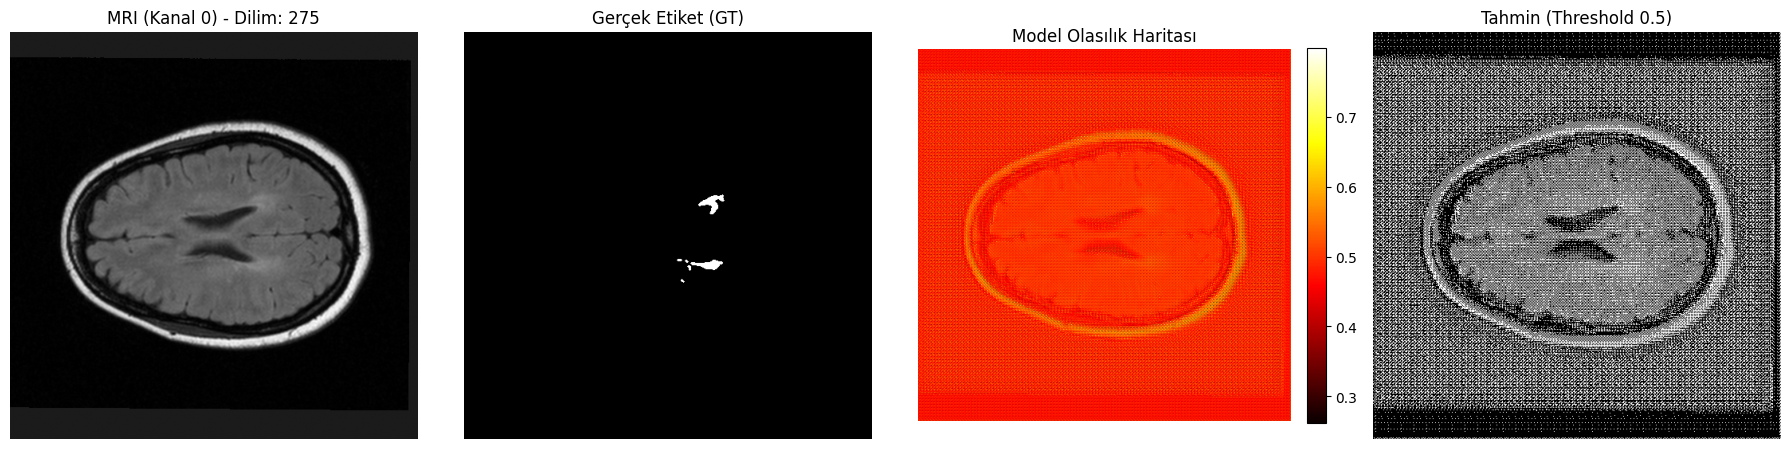

Olasılık Maksimum Değeri: 0.8999
Olasılık Ortalama Değeri: 0.4694


In [101]:
def visualize_results(model, loader, device, slice_idx=None):
    model.eval()

    batch = next(iter(loader))
    inputs = batch["image"].to(device)
    labels = batch["label"].to(device)

    with torch.no_grad():
        logits = model(inputs)
        probs = torch.sigmoid(logits)


    img_mri = inputs[0, 0].cpu().numpy()
    img_fcm = inputs[0, 1].cpu().numpy()
    gt = labels[0, 0].cpu().numpy()
    prediction_probs = probs[0, 0].cpu().numpy()

    if slice_idx is None:
        slice_idx = gt.shape[-1] // 2
        if np.sum(gt) > 0:
            slice_idx = np.argmax(np.sum(gt, axis=(0, 1)))

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.title(f"MRI (Kanal 0) - Dilim: {slice_idx}")
    plt.imshow(img_mri[:, :, slice_idx], cmap="gray")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("Gerçek Etiket (GT)")
    plt.imshow(gt[:, :, slice_idx], cmap="gray")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("Model Olasılık Haritası")
    im = plt.imshow(prediction_probs[:, :, slice_idx], cmap="hot")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Tahmin (Threshold 0.5)")
    plt.imshow(prediction_probs[:, :, slice_idx] > 0.5, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Olasılık Maksimum Değeri: {prediction_probs.max():.4f}")
    print(f"Olasılık Ortalama Değeri: {prediction_probs.mean():.4f}")

visualize_results(model, val_loader, device)